# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Saron Goitom

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [4]:
# Import libraries
#!pip install pandas
#!pip install scikit-learn
#!pip install keras
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [5]:
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [7]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

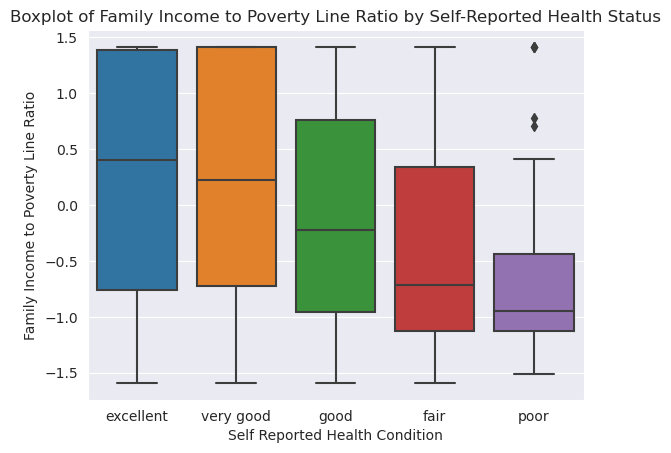

In [7]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

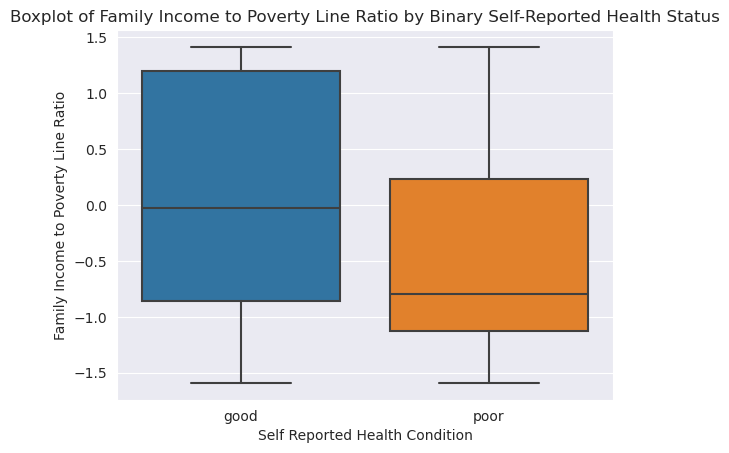

In [8]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

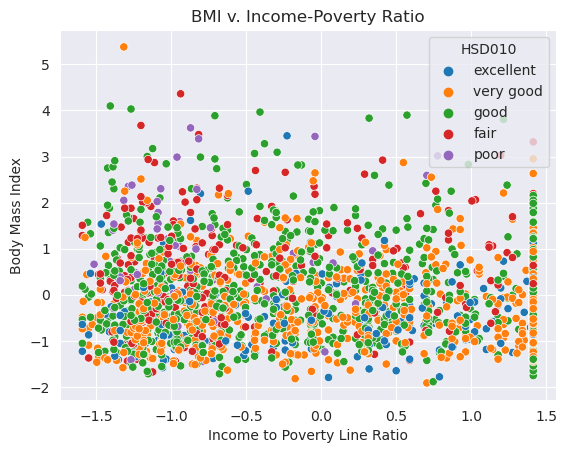

In [9]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [10]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

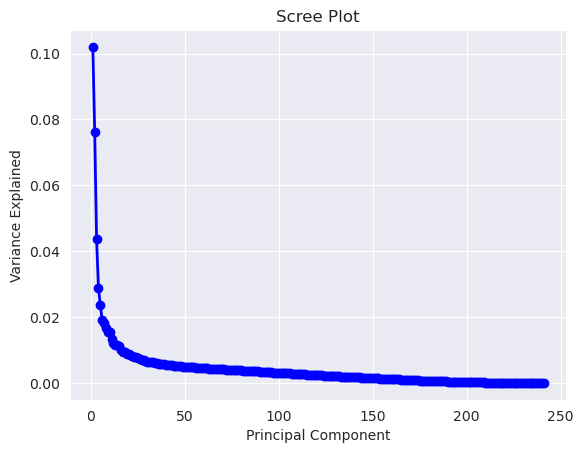

In [11]:
#apply PCA
pca = PCA(n_components=2)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

# convert into a dataframe
# ----------
pca_df = pd.DataFrame(data = principalComponents_nhanes, 
                      columns = ['principal component 1', 
                                 'principal component 2'])

pca_df.head()

#assess how many components to keep using scree plot
#
# Create a Scree plot to evaluate the number of components to keep
# --------------------------------------------------

# fit PCA
# ----------
pca_all = PCA() # notice we do not specify the number of components if we want to keep them all
principalComponents_nhanes = pca_all.fit_transform(nhanes_scaled)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
Starting off small with 2 components and building up with more components. 

### Barplot of Components

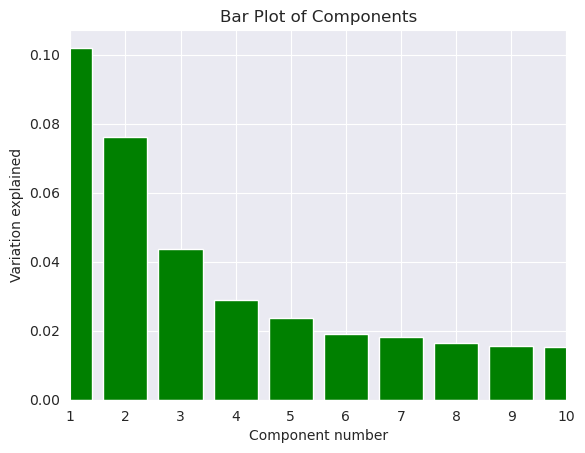

In [12]:
# Plotting the bar plot
plt.bar(PC_values, pca_all.explained_variance_ratio_, color='green')

# Adding labels and title
plt.xlabel('Component number')
plt.ylabel('Variation explained')
plt.title('Bar Plot of Components')

#include this piece to limit x-axis range to 1-10
plt.xlim(1, 10) 

# Display the plot
plt.show()

### How many components will you use to fit a supervised learning model?

In [13]:
The biggest drop off where we see diminishing returns in the scree plot is between 5 and 6 components. 

SyntaxError: invalid syntax (2877857804.py, line 1)

### 2D Scatterplot of the first two components

In [14]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')

nhanes_scaled['HSD010'] 

SEQN
73568    1
73576    1
73579    2
73581    2
73584    3
        ..
83694    3
83696    2
83704    4
83716    1
83721    2
Name: HSD010, Length: 2064, dtype: int64

In [15]:
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010

In [16]:
#checking that appropriate variables are in the datasets
nhanes_scaled_columns = nhanes_scaled.columns
print("Column names of nhanes_scaled:", nhanes_scaled_columns)

pca_df_columns = pca_df.columns
print("Column names of pca_df:", pca_df_columns)

Column names of nhanes_scaled: Index(['DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH', 'DR1DAY',
       'DR1LANG', 'DR1MNRSP', 'DR1HELPD', 'DBQ095Z',
       ...
       'OHQ845', 'PAAQUEX', 'SMQ860', 'SMQ870', 'SMQ872', 'SMQ874', 'SMQ878',
       'SMAQUEX.x', 'HSD010', 'SEQN'],
      dtype='object', length=243)
Column names of pca_df: Index(['principal component 1', 'principal component 2'], dtype='object')


In [17]:
hsd010 = hsd010.replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
print(hsd010)

0       excellent
1       excellent
2       very good
3       very good
4            good
          ...    
2059         good
2060    very good
2061         fair
2062    excellent
2063    very good
Name: HSD010, Length: 2064, dtype: object


<Figure size 640x480 with 0 Axes>

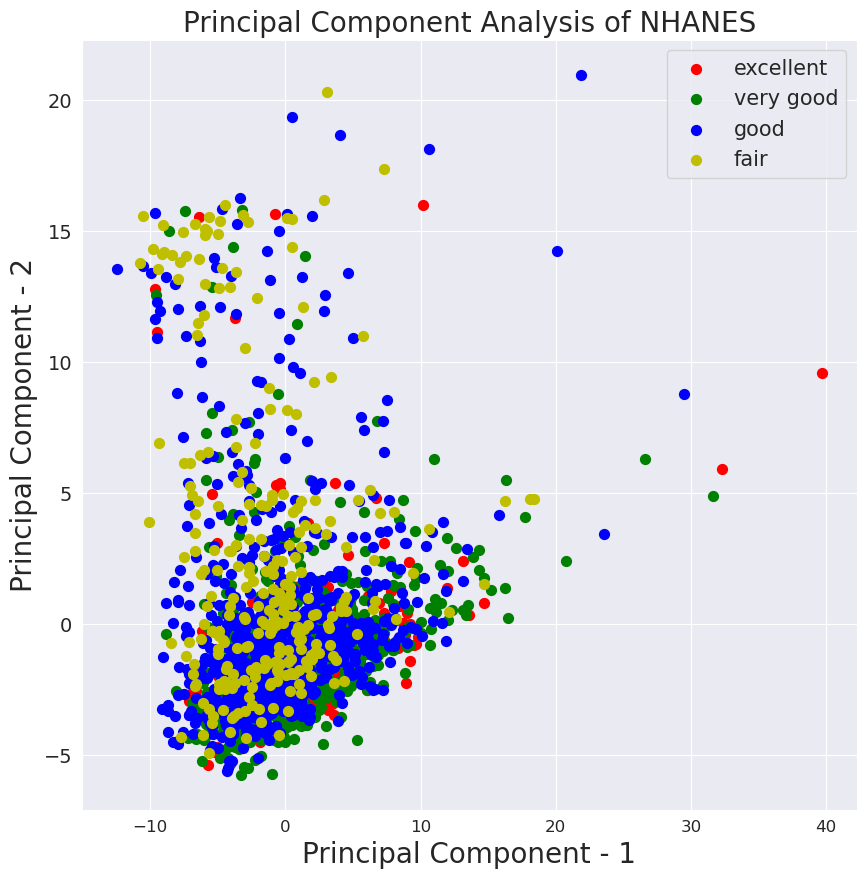

In [18]:
# plot
# ----------


# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES",fontsize=20)
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['r', 'g', 'b', 'y']


# loop over targets and colors to create scatterplot
for target, color in zip(targets,colors):
    indicesToKeep = hsd010 == target
    indicesToKeep = indicesToKeep.reset_index(drop=True) #had to add this line
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

# show figure
plt.legend(targets,prop={'size': 15})
plt.show();

In [ ]:
The different categories of the perceived health variables are scattered evenly and overlapping each other, 
showing very little variation.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

In [19]:
# load libraries 
# ----------
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# settings
%matplotlib inline

In [20]:
np.random.seed(10)

In [21]:
#reimporting data, scaling, w/out changing target variable to string

# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
#nhanes_scaled.head()

In [22]:
X=nhanes_scaled

In [23]:
df = pd.DataFrame(X)

nhanes_scaled_columns = X.columns
print("Column names of nhanes_scaled:", nhanes_scaled_columns)

Column names of nhanes_scaled: Index(['DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH', 'DR1DAY',
       'DR1LANG', 'DR1MNRSP', 'DR1HELPD', 'DBQ095Z',
       ...
       'OHQ770', 'OHQ845', 'PAAQUEX', 'SMQ860', 'SMQ870', 'SMQ872', 'SMQ874',
       'SMQ878', 'SMAQUEX.x', 'HSD010'],
      dtype='object', length=242)


In [24]:
#not sure if we're supposed to do this, but otherwise there are many centers

# Keep only two variables (columns)
selected_columns = ["INDFMPIR", "BMXBMI"]
df_subset = df[selected_columns]

# Display the resulting DataFrame
print(df_subset)

X=df_subset

       INDFMPIR    BMXBMI
SEQN                     
73568  1.412214 -1.001972
73576 -0.642017 -0.618783
73579  0.192890 -1.636215
73581  1.412214 -0.565929
73584  0.252955 -0.341301
...         ...       ...
83694  0.343053 -0.341301
83696 -1.092507  0.081527
83704 -1.591048  1.508575
83716  0.589320 -0.499862
83721  1.412214 -0.301661

[2064 rows x 2 columns]


In [25]:
array_representation =X.values
array_representation

array([[ 1.41221429, -1.00197156],
       [-0.64201717, -0.61878288],
       [ 0.19288976, -1.63621489],
       ...,
       [-1.59104808,  1.50857496],
       [ 0.5893204 , -0.49986226],
       [ 1.41221429, -0.30166122]])

### Cluster nhanes

In [ ]:
I chose the kmeans clustering approach, which partitions the dataset into K distinct, non-overlapping clusters.

In [26]:
# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300 #default
                ).fit(array_representation)


In [27]:
# print the centers 
print("Centers")
print(kmeans.cluster_centers_)
print()

# print labels
print("Labels")
print(kmeans.labels_)
print()

# print coordinates and labels 
for point, label in zip(array_representation, kmeans.labels_):
    print("Coordinates:", point, "Label:", label)

Centers
[[-0.81888321 -0.47385036]
 [ 1.04287675 -0.30829266]
 [-0.36162984  1.46963339]]

Labels
[1 0 0 ... 2 1 1]

Coordinates: [ 1.41221429 -1.00197156] Label: 1
Coordinates: [-0.64201717 -0.61878288] Label: 0
Coordinates: [ 0.19288976 -1.63621489] Label: 0
Coordinates: [ 1.41221429 -0.56592927] Label: 1
Coordinates: [ 0.25295501 -0.34130142] Label: 1
Coordinates: [-0.23357349  0.29294191] Label: 0
Coordinates: [0.40912465 1.42929454] Label: 2
Coordinates: [0.26496806 0.43828934] Label: 1
Coordinates: [1.41221429 1.37644093] Label: 1
Coordinates: [ 0.96172493 -0.89626434] Label: 1
Coordinates: [1.41221429 1.48214815] Label: 2
Coordinates: [-1.08650001 -0.07703337] Label: 0
Coordinates: [ 0.37308551 -0.2091674 ] Label: 1
Coordinates: [-1.30874142  0.05510066] Label: 0
Coordinates: [0.54727472 0.34579552] Label: 1
Coordinates: [-0.720102    0.31936871] Label: 0
Coordinates: [-0.22756697  1.31037392] Label: 2
Coordinates: [1.41221429 0.17402128] Label: 1
Coordinates: [-0.51588016  0.43

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

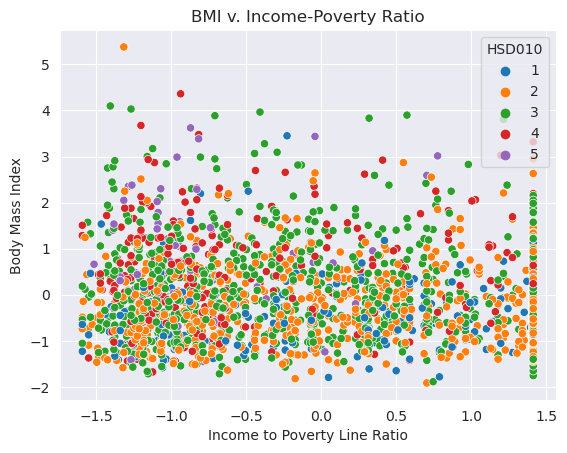

In [28]:
#first w/o clusters

ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

In [ ]:
In the above plot, we don't see much of a relationship between perceived health and BMI/Income-Poverty Ratio.

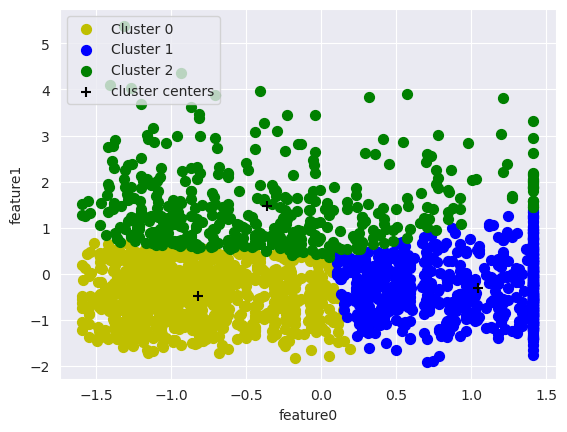

In [29]:
# with clusters
# figure settings
fig = plt.figure()
ax1 = fig.add_subplot(111)

# plot
ax1.scatter(*array_representation[kmeans.labels_==0,:].T, s=50, c='y', label='Cluster 0')
ax1.scatter(*array_representation[kmeans.labels_==1,:].T, s=50, c='b', label='Cluster 1')
ax1.scatter(*array_representation[kmeans.labels_==2,:].T, s=50, c='g', label='Cluster 2')
ax1.scatter(*kmeans.cluster_centers_.T, s=50, marker='+', c='black', label='cluster centers')
plt.legend(loc='upper left')
plt.xlabel('feature0')
plt.ylabel('feature1')
plt.show()

We see the clusters are clearly defined with regards to the original data. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

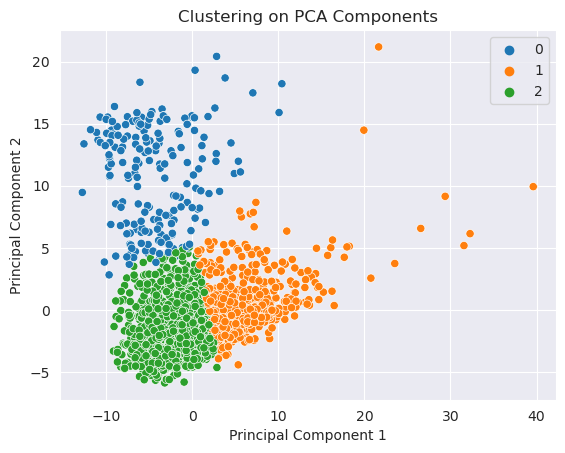

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# Perform PCA to double check
pca = PCA(n_components=3)
pca_components = pca.fit_transform(nhanes_scaled)

# Retrain KMeans on PCA components
kmeans_pca = KMeans(n_clusters=3, n_init=10, max_iter=300, random_state=42)
labels_pca = kmeans_pca.fit_predict(pca_components)

# Create a scatter plot for the first two principal components
ax = sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=labels_pca, palette="tab10")

# Set axis labels and title
ax.set(xlabel="Principal Component 1", ylabel="Principal Component 2")
ax.set_title("Clustering on PCA Components")

# Display the plot
plt.show()

The clustering of the observations perform well with the PCA features.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [8]:
# partition data
# -----------
y = nhanes_scaled['HSD010'] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled.drop(['HSD010'], axis=1) # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [9]:
# load libraries
# -----------
import tensorflow
from keras.utils import to_categorical

num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [10]:
# create neural network model
# -----------
from keras.models import Sequential
from keras.layers import Dense

#def NN_model():
model = Sequential()

model.add(Dense(y_train.shape[1], input_dim= X_train.shape[1], kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(y_train.shape[1], kernel_initializer= 'normal', activation= 'softmax'))

    ## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

    #model = NN_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# Evaluation of the model
#scores = model.evaluate(X_test, y_test, verbose=0)

#print("NN Error: %.2f%%" % (100-scores[1]*100))
#print(model.summary())



Epoch 1/10
8/8 - 1s - loss: 2.2669 - accuracy: 0.1699 - val_loss: 2.2473 - val_accuracy: 0.1957 - 886ms/epoch - 111ms/step
Epoch 2/10
8/8 - 0s - loss: 2.2070 - accuracy: 0.3127 - val_loss: 2.1882 - val_accuracy: 0.3081 - 47ms/epoch - 6ms/step
Epoch 3/10
8/8 - 0s - loss: 2.1380 - accuracy: 0.3882 - val_loss: 2.1170 - val_accuracy: 0.3702 - 56ms/epoch - 7ms/step
Epoch 4/10
8/8 - 0s - loss: 2.0559 - accuracy: 0.4238 - val_loss: 2.0309 - val_accuracy: 0.3934 - 48ms/epoch - 6ms/step
Epoch 5/10
8/8 - 0s - loss: 1.9590 - accuracy: 0.4477 - val_loss: 1.9318 - val_accuracy: 0.4070 - 73ms/epoch - 9ms/step
Epoch 6/10
8/8 - 0s - loss: 1.8527 - accuracy: 0.4509 - val_loss: 1.8257 - val_accuracy: 0.4147 - 50ms/epoch - 6ms/step
Epoch 7/10
8/8 - 0s - loss: 1.7444 - accuracy: 0.4567 - val_loss: 1.7223 - val_accuracy: 0.4186 - 51ms/epoch - 6ms/step
Epoch 8/10
8/8 - 0s - loss: 1.6433 - accuracy: 0.4619 - val_loss: 1.6282 - val_accuracy: 0.4244 - 50ms/epoch - 6ms/step
Epoch 9/10
8/8 - 0s - loss: 1.5523 - 

### Neural Network on Principal Components

In [11]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=10)  # Choose the number of principal components
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)
#neural network model
model = Sequential()
model.add(Dense(units=128, input_dim=10, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
52/52 [==============================] - 1s 6ms/step - loss: -0.8108 - accuracy: 0.0830 - val_loss: -5.1555 - val_accuracy: 0.1162
Epoch 2/10
52/52 [==============================] - 0s 3ms/step - loss: -8.7415 - accuracy: 0.1157 - val_loss: -13.3081 - val_accuracy: 0.1162
Epoch 3/10
52/52 [==============================] - 0s 3ms/step - loss: -18.1202 - accuracy: 0.1157 - val_loss: -24.8107 - val_accuracy: 0.1162
Epoch 4/10
52/52 [==============================] - 0s 3ms/step - loss: -31.4960 - accuracy: 0.1157 - val_loss: -41.1022 - val_accuracy: 0.1162
Epoch 5/10
52/52 [==============================] - 0s 3ms/step - loss: -50.1817 - accuracy: 0.1157 - val_loss: -63.6256 - val_accuracy: 0.1162
Epoch 6/10
52/52 [==============================] - 0s 3ms/step - loss: -75.4611 - accuracy: 0.1157 - val_loss: -92.9788 - val_accuracy: 0.1162
Epoch 7/10
52/52 [==============================] - 0s 3ms/step - loss: -108.0439 - accuracy: 0.1157 - val_loss: -130.7700 - val_accuracy: 

### Neural Network on Principal Components + Cluster Membership

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Combine principal components and cluster membership
X_combined = np.concatenate((X_pca, clusters.reshape(-1, 1)), axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)


# Build the neural network
model_combined = Sequential()
model_combined.add(Dense(units=128, input_dim=11, activation='relu'))  # Adjust input_dim based on the combined feature size
model_combined.add(Dense(units=1, activation='sigmoid'))

model_combined.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_combined.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
52/52 [==============================] - 1s 5ms/step - loss: -5.0126 - accuracy: 0.1108 - val_loss: -9.8145 - val_accuracy: 0.1162
Epoch 2/10
52/52 [==============================] - 0s 3ms/step - loss: -14.9394 - accuracy: 0.1157 - val_loss: -21.6973 - val_accuracy: 0.1162
Epoch 3/10
52/52 [==============================] - 0s 3ms/step - loss: -29.2866 - accuracy: 0.1157 - val_loss: -39.4305 - val_accuracy: 0.1162
Epoch 4/10
52/52 [==============================] - 0s 3ms/step - loss: -50.2065 - accuracy: 0.1157 - val_loss: -65.4477 - val_accuracy: 0.1162
Epoch 5/10
52/52 [==============================] - 0s 3ms/step - loss: -79.2799 - accuracy: 0.1157 - val_loss: -100.2397 - val_accuracy: 0.1162
Epoch 6/10
52/52 [==============================] - 0s 3ms/step - loss: -117.9221 - accuracy: 0.1157 - val_loss: -144.7626 - val_accuracy: 0.1162
Epoch 7/10
52/52 [==============================] - 0s 3ms/step - loss: -166.4039 - accuracy: 0.1157 - val_loss: -200.6441 - val_accura

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA or Principal Components Analysis, and clustering are similar in that they use data summarization techniques to simplify the data. However, they differ in key ways. Specifically, PCA is a type of unsupervised learning approach which reduces the dimension of a large set of features. The new set of features are linear combinations of the original features, peserve variation in the data, and represent a new orthogonal coordinate system. Clustering involves grouping similar observations of a dataset together.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

Combining PCA and clustering yielded an improvement in the performance of the model, compared to their 
performance alone. Specifically, clustering alone made it challenging to interpret the relationship between
BMI/Income-Poverty Ratio and perceived health, while PCA alone shows very little variability in the perceived
health responses. 

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

In [ ]:
The main uses of unsupervised techniques include exploratory data analysis and data simplication/preprocessing 
(as was done with the PCA in this project). Given the complexities in analyzing 'big data', these techniques 
provide great ways to 'prep' the data for more downstreatm supervised learning tasks. 